In [24]:
# To start this notebook with more than one thread, change the extension setting in vs, search for thread,
# and change the Max Threads as well as settings.json.
# This will speed up the computations for running multiple chains. 

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())
nr_chains = 4 # number of chains to sample, corresponding to the thread
results_dir = "results_section_6_1_AM_10^6"

4


"results_section_6_1_AM_10^6"

In [25]:
# using Pkg
# Pkg.add("Turing")
using Plots # to plot things
using Random, Distributions # generate random noise
using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 

using QuadGK
using BasicBSpline
using LaTeXStrings

using Optim # for ML and MAP estimation 

# Pkg.add("AdaptiveMCMC")
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 

using Printf  # Import Printf for formatted output
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using SparseArrays

include("../src/Mesh_fun.jl")
include("../src/FE_fun.jl")
include("../src/SIACMatrix.jl")

PostProcess (generic function with 1 method)

# Problem setup

In [26]:
# define test function
# testFun(x)=@. 2*x*sin(pi*x)
testFun(x)=@. sin(2*pi*x)+0.5*cos(4pi*x)^2 + 0.5

# define parameters
N = 100 # number of points

# generate true physical data on the uniform grid
xx = collect(LinRange(0,1,N))
fx = testFun(xx)

# variance of the iid Gaussian noise added to the measurements
σ² = 0.05

# forward operator, noise, and noisy data
# forward operator -- use the identity matrix for now
F = Matrix(1.0I, N, N)  # Identity matrix of Float64 type
Random.seed!(123) # Setting the seed
noise = rand( Normal(0,sqrt(σ²)), N )
fx_noisy = F * fx + noise

# SIAC matrix
# Piecewise Polynomial Setup for SIAC Filter
p = 3
# Create SIAC Matrix, with periodic boundary treatment
Ffil = global_SIAC_Mat(p, xx, boundaryTreatment="periodic")
# filtered noisy data
fx_noisy_filter = Ffil*fx_noisy

100-element Vector{Float64}:
 1.0254291208625161
 1.0268663337405446
 1.0227281782144504
 1.0237599058425901
 1.033618676455094
 1.0507365397560984
 1.0704652600331472
 1.0964250236281532
 1.1255150010132067
 1.1499535228277629
 ⋮
 0.2557035377952046
 0.32889114284593607
 0.39858678489446414
 0.4782188471310769
 0.5764140429354622
 0.6949851812050467
 0.8203580155918291
 0.9260039944511835
 0.9957298870854775

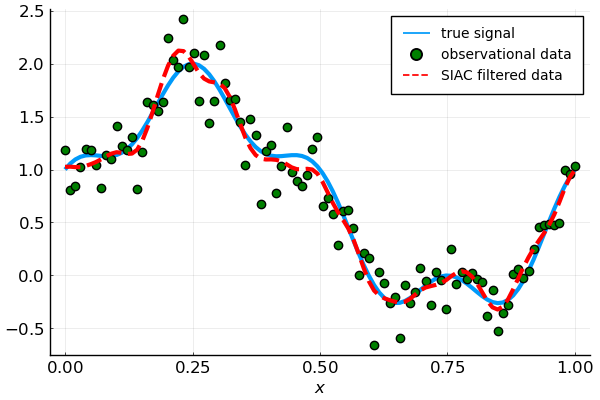

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250602code_TL/notebooks/results_section_6_1_AM_10^6/data.png"

In [27]:
# Plot underlying true function, noisy data, and filtered data
pyplot() 
# Create the plot for the underlying true function
plot_fx = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add noisy data  
Plots.scatter!(plot_fx, 
    xx, fx_noisy; 
    label="observational data", 
    markercolor = :green, markersize = 6, marker_alpha = 0.6 
)
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Make some cosmetic changes to the plot 
Plots.plot!( plot_fx,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_fx)
# Save the plot
savefig(plot_fx, joinpath(results_dir, "data.png"))  # Save as PNG

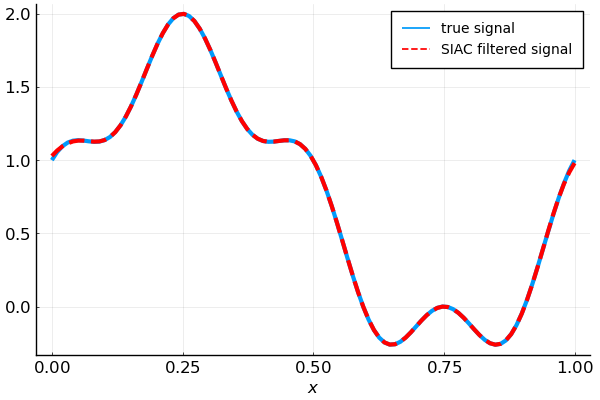

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250602code_TL/notebooks/results_section_6_1_AM_10^6/true_signal.png"

In [28]:
# Check SIAC filter applied on the underlying true function
# filtered data
fx_filter = Ffil*fx

pyplot() 
# Create the plot for the underlying true function
plot_fx_check = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_check, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered data 
Plots.plot!(plot_fx_check, 
    xx, fx_filter;     
    label="SIAC filtered signal",
    lw=3, ls=:dash, lc=:red 
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_check,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_fx_check)
# Save the plot
savefig(plot_fx_check, joinpath(results_dir, "true_signal.png"))  # Save as PNG

# Statistical model setup

We consider the following model: 
\begin{align*}
    \mathbf{fx\_noisy} & \sim \mathcal{N}(F\mathbf{u},\sigma^2*I) = \mathcal{N}(F\mathbf{u},\alpha^{-1}*I), \\
    R \mathbf{u} & \sim \mathcal{N}(\mathbf{0},\beta^{-1}*I), \\ 
\end{align*}
where $R$ is the regularization operator. 
The associated posterior log PDF is 
$$            
                -\frac{\alpha}{2}  \| F\mathbf{u} - \mathbf{fx\_noisy} \|_2^2 
                -\frac{\beta}{2}  \| R\mathbf{u} \|_2^2 
                - d \alpha - d\beta + (\frac{N}{2}+c-1)\log \alpha + (\frac{N}{2}+c-1)\log \beta.
$$

In [29]:
# Set up the statistical model

# regularization operator
R = Matrix(1.0I, N, N) - Ffil

c = 1
d = 1.0e-3
# Define the posterior log-PDF for both unknown signal and hyperparameters  
function logpdf_posterior(u, α, β) 
    if α<=0 || β<=0
        logpdf = -Inf
    else
        logpdf = -(.5α)*norm(F*u-fx_noisy)^2 -(.5β)*norm(R*u)^2 - d*α - d*β + (N/2+c-1)*log(α) + (N/2+c-1)*log(β)
    end
        
    return logpdf
end

# Define the log-PDF by grouping all the parameters
logpdf(z) = logpdf_posterior(z[1:end-2], z[end-1], z[end])
# Define the negative log-PDF
neg_logpdf(z) = -logpdf(z)

neg_logpdf (generic function with 1 method)

# MAP estimate

We will compare the MAP estimates obtained from the built-in optimizer (limited-memory Broyden–Fletcher–Goldfarb–Shanno L-BFGS algorithm) and the Block Coordinate Descent (BCD) algorithm.

## L-BFGS

In [30]:
# Obtain MAP estimate using built-in optimizer L-BFGS

# Initial guess for the optimization (u, α and β)
initial_guess = vcat(zeros(N), 1.0, 1.0)

tLBFGS = @elapsed begin # execution time    
    # MAP estimation
    map_estimate = optimize(neg_logpdf, initial_guess, LBFGS())
end
    
# Extract the MAP estimate of u
fx_LBFGS_tmp = Optim.minimizer(map_estimate)
fx_LBFGS = fx_LBFGS_tmp[1:end-2]

100-element Vector{Float64}:
 0.9896662196544338
 1.0249455498945579
 1.049657113795034
 1.0652611057584773
 1.073085928329253
 1.0753323697550539
 1.0738892489942902
 1.072262701863015
 1.0732125736976978
 1.0794126791214276
 ⋮
 0.20685553194027634
 0.3172180095090052
 0.4278237669226416
 0.5355547516351646
 0.6369500691674088
 0.7298833435522877
 0.8125649725983322
 0.8837274592127752
 0.9426377931682263

## BCD

In [31]:
# set up BCD function
using SparseArrays

function BCD_1d_scalar(F, y, R, c, d, QUIET)

    t_start = time()  # Measure time

    # Global constants and defaults
    MIN_ITER = 0
    MAX_ITER = 1000
    ABSTOL = 1e-8
    RELTOL = 1e-4

    # Data preprocessing
    m, n = size(F)  # number of (indirect) measurements and pixels
    k = size(R, 1)  # number of outputs of the regularization operator
    FtF = sparse(F' * F)  # product corresponding to the forward operator
    Fty = F' * y  # forward operator applied to the indirect data

    # Initial values for the inverse variances and the mean and others
    aalpha = 0.1
    bbeta = 1
    mu = zeros(n)
    mu_OLD = zeros(n)  # mean

    C_inv = Matrix(1.0I, n, n)

    abs_error = 0
    rel_error = 0

    if !QUIET
        println("iter\t abs error\t abs tol\t rel error\t rel tol")
    end

    # Iterate between the update steps until convergence or max number of iterations
    for counter in 1:MAX_ITER

        # 1) Fix aalpha, bbeta, and update x
        C_inv = sparse(aalpha * FtF + bbeta * R' * R)  # update covariance matrix
        mu = C_inv \ (aalpha * Fty)  # update the mean

        # 2) Fix x, B and update aalpha
        aalpha = (m + 2 * c) / (norm(F * mu - y)^2 + 2 * d)

        # 3) Fix x, aalpha and update B
        bbeta = (n + 2 * c) / (norm(R * mu)^2 + 2 * d)

        # Store certain values in history structure
        abs_error = norm(mu - mu_OLD)^2  # absolute error
        rel_error = (norm(mu - mu_OLD) / norm(mu_OLD))^2  # relative error

        mu_OLD = mu  # store value of mu

        if !QUIET
            println("$(counter)\t $(abs_error)\t $(ABSTOL)\t $(rel_error)\t $(RELTOL)")
        end

        # Check for convergence
        if abs_error < ABSTOL && rel_error < RELTOL && counter > MIN_ITER
            break
        end

    end

    # Output the time it took to perform all operations
    if !QUIET
        println("Elapsed time: ", time() - t_start, " seconds")
    end

    return mu, C_inv, aalpha, bbeta, Dict("abs_error" => abs_error, "rel_error" => rel_error)
end

BCD_1d_scalar (generic function with 1 method)

In [32]:
# Obtain MAP estimate using BCD algorithm
tBCD = @elapsed begin # execution time

    fx_BCD, C_inv, aalpha, bbeta, history = BCD_1d_scalar(F, fx_noisy, R, c, d, false ); 
    
end

iter	 abs error	 abs tol	 rel error	 rel tol
1	 108.01713463921439	 1.0e-8	 Inf	 0.0001
2	 0.1008690037317874	 1.0e-8	 0.0009338241017843853	 0.0001
3	 0.06835619187844917	 1.0e-8	 0.0006342583531601523	 0.0001
4	 0.0034393450745363874	 1.0e-8	 3.195162123908988e-5	 0.0001
5	 4.167835195122321e-6	 1.0e-8	 3.872637420001169e-8	 0.0001
6	 2.8338742803050538e-9	 1.0e-8	 2.6331746901783367e-11	 0.0001
Elapsed time: 0.003484964370727539 seconds


0.016057042

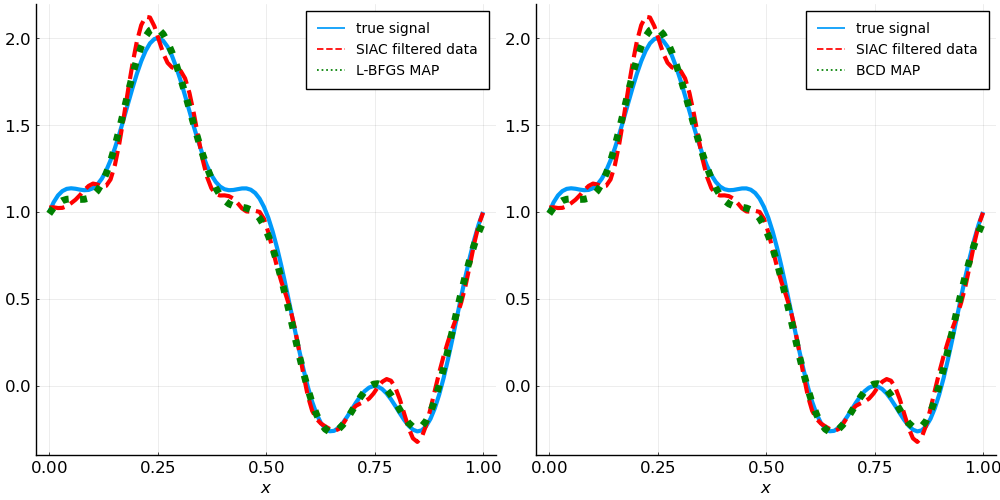

In [33]:
# Plot underlying true function, noisy data, and MAP estimates
pyplot() 
# Create the plot for the underlying true function
plot_fx_MAP1 = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_MAP1, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx_MAP1, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Add MAP estimate from built-in optimizer
Plots.plot!(plot_fx_MAP1, 
    xx, fx_LBFGS;     
    label="L-BFGS MAP",
    lw=5, ls=:dot, lc=:green
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_MAP1,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)

# Create the plot for the underlying true function
plot_fx_MAP2 = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_MAP2, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx_MAP2, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Add MAP estimate from BCD algorithm
Plots.plot!(plot_fx_MAP2, 
    xx, fx_BCD;     
    label="BCD MAP",
    lw=5, ls=:dot, lc=:green
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_MAP2,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Combine the plots
plot_MAPs = Plots.plot(plot_fx_MAP1, plot_fx_MAP2, layout=(1, 2), size = (1000,500))
# Save the plot
savefig(plot_fx_MAP1, joinpath(results_dir, "MAP_LBFGS.png"))  # Save as PNG
savefig(plot_fx_MAP2, joinpath(results_dir, "MAP_BCD.png"))  # Save as PNG
# Display the plot
display(plot_MAPs)

In [34]:
# Compare the execution times for MAP estimates
println(@sprintf("Time for MAP estimate with LBFGS: %-15.4f seconds", tLBFGS))
println(@sprintf("Time for MAP estimate with BCD:   %-15.4f seconds", tBCD))

# Compute relative L2 errors
rel_l2_err_LBFGS = norm(fx_LBFGS - fx) / norm(fx)
rel_l2_err_BCD = norm(fx_BCD - fx) / norm(fx)

# Compare relative L2 errors
println(@sprintf("Relative l2 error for MAP estimate with LBFGS: %-15.4e", rel_l2_err_LBFGS))
println(@sprintf("Relative l2 error for MAP estimate with BCD:   %-15.4e", rel_l2_err_BCD))


Time for MAP estimate with LBFGS: 2.2094          seconds
Time for MAP estimate with BCD:   0.0161          seconds
Relative l2 error for MAP estimate with LBFGS: 4.8448e-02     
Relative l2 error for MAP estimate with BCD:   4.8457e-02     


# Sampling

We will compare the performance of Gibbs sampling and AM sampling. Here we do AM sampling.

## Generate random initializations

In [35]:
## Genrate random samples from the original prior 

# Set-up an array for the initializations 
initial_random = Array{Float64}(undef, N+2, nr_chains)

# Generate α- and β-samples from the gamma distribution
α_random = rand(Gamma(c, 1/d), nr_chains)
β_random = rand(Gamma(c, 1/d), nr_chains)

# Get corresponding u-sample by performing an x-update 
u_random = Array{Float64}(undef, N, nr_chains)
for j in 1:nr_chains
    α = α_random[j]
    β = β_random[j]
    C_inv = sparse(α*F'*F + β*R'*R)  # update covariance matrix
    u_random[:,j] = C_inv \ (α*F'*fx_noisy)  # update the mean
end

# Collect the α-, β-, and u-samples
for j in 1:nr_chains
    initial_random[1:end-2,j] .= u_random[:,j]
    initial_random[end-1,j] = α_random[j]
    initial_random[end,j] = β_random[j]
end

In [36]:
# Initialization option: "MAP", "random"
init = "random" 

# Choose an initialization for the MCMC chains 
init_param = Array{Float64}(undef, N+2, nr_chains)

# Use MAP estimate 
if init=="MAP"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param[:,j] = fx_MAP_tmp
    end

# Use random initializations 
elseif init=="random"
    init_param = initial_random

# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'random'.")
end

102×4 Matrix{Float64}:
    0.984005    1.09664      1.10148      1.15873
    1.02001     0.914666     0.90815      0.832479
    1.04646     0.935891     0.930583     0.870039
    1.0645      1.01832      1.01876      1.02463
    1.075       1.10329      1.10879      1.17331
    1.07979     1.10827      1.11295      1.16755
    1.07992     1.04753      1.04701      1.04136
    1.07906     0.964177     0.95599      0.860842
    1.07957     1.13545      1.13545      1.13828
    1.08387     1.1421       1.13991      1.11203
    ⋮                                  
    0.432926    0.435288     0.43741      0.464405
    0.539259    0.48604      0.485803     0.486551
    0.638543    0.532967     0.529498     0.491924
    0.729172    0.603808     0.597638     0.525446
    0.809787    0.908946     0.914257     0.976029
    0.879208    0.941416     0.943008     0.957099
    0.937053    1.01155      1.01312      1.02845
    3.06675   188.036     1174.33      1582.06
 3585.16      206.361     1144.

## AM Sampling

In [37]:
# https://mvihola.github.io/docs/AdaptiveMCMC.jl
# Prepare arguments. 
# nr_chains = 4 # number of chains to sample 
nr_samples_raw = 10^6 # number of samples 
# thin = 10^1 # Thinning factor; only every thin:th sample is stored 
thin = 1 # Thinning factor; only every thin:th sample is stored 
burn_in_raw = Int64(ceil(nr_samples_raw/10)) # Burn-in length of 10%
# burn_in_raw = 0

# number of (burn-in) samples after thinning 
# nr_samples = Int64( nr_samples_raw/thin )
nr_samples = Int64( nr_samples_raw/thin )
burn_in = Int64(ceil(nr_samples/10)) # Burn-in length of 10%
# burn_in = 0

# number of parameters 
nr_params_AM = N+2 

102

In [38]:
# using Pkg
# Produce samples from the target distribution.
# Note: Looking at the acceptance rate, :asm seems to work the best

# Initialize
AM_chn_values = zeros(Float64, nr_samples-burn_in, nr_params_AM, nr_chains)

# Start the wall clock timer
wall_start = now()
t_start = time()

j=1
# Use multiple threads. 
@showprogress Threads.@threads for j in 1:nr_chains 
    # generate samples
    AM_chn_values[:,:,j] = adaptive_rwm(
        init_param[:,j], 
        logpdf, 
        nr_samples_raw; # raw number of samples  
        algorithm=:asm, 
        b=burn_in_raw+1, # burn in length 
        # thin=thin, # Thinning factor
        progress=true # show progress meter
    ).X'
    
    # Clear memory after each chain
    GC.gc()
end

# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
t_time = time() - t_start
# Convert wall duration to seconds
AM_wall_duration = Dates.value(wall_duration_ms) / 1000

# Interleave θ and z names
param_names = Vector{String}(undef, nr_params_AM)
param_names[1:N] .= [string("u[", i, "]") for i in 1:N ]
param_names[end-1] = "α"
param_names[end] = "β"

# Create the Chains object
AM_chn = Chains(AM_chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
AM_chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

# Display the results
println("AM sampling completed.")
print(t_time)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05:54
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


AM sampling completed.
13.323667049407959

In [39]:
# Initialize an array to store acceptance rates for each chain
acceptance_rates = zeros(nr_chains) 

# Compute the acceptance rate for each chain
Threads.@threads for j in 1:nr_chains
    accepted = 0
    for i in 2:size(AM_chn.value, 1)
        # Compare z parameters between successive iterations
        if any(AM_chn.value[i, :, j] .!= AM_chn.value[i-1, :, j])
            accepted += 1
        end
    end
    acceptance_rate = accepted / (nr_samples - 1)
    acceptance_rates[j] = acceptance_rate
end

# Compute the average acceptance rate
average_acceptance_rate = mean(acceptance_rates)

# Print acceptance rates for each chain
for (j, rate) in enumerate(acceptance_rates)
    println("Chain $j acceptance rate: $rate")
end
println("Average acceptance rate: $average_acceptance_rate")

Chain 1 acceptance rate: 0.2101762101762102
Chain 2 acceptance rate: 0.21098121098121098
Chain 3 acceptance rate: 0.2108032108032108
Chain 4 acceptance rate: 0.2102922102922103
Average acceptance rate: 0.21056321056321053


### Traces for a specific location

We focus on investigating  $(u[j],\alpha,\beta)$ for $j=50$.
Note that $t[j] \approx 0.5$ and $u_{\rm true}[j] \approx 0.52$ for $j=50$.

In [40]:
# Extract sample values 
j = 50 

# Get the u-samples
AM_u_j = get(AM_chn, :u).u[j]
# Get the α-samples
AM_α = get(AM_chn, :α).α
# Get the β-samples
AM_β = get(AM_chn, :β).β

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:900000
    :chain, 1:4
And data, a 900000×4 Matrix{Float64}:
 3583.47  207.869  1141.56  250.275
 3583.47  207.869  1141.56  250.275
 3583.47  207.869  1141.56  250.275
 3583.47  207.866  1141.56  250.275
 3583.47  207.866  1141.56  250.274
 3583.47  207.866  1141.56  250.274
 3583.47  207.866  1141.56  250.274
 3583.47  207.866  1141.57  250.274
 3583.47  207.866  1141.57  250.274
 3583.47  207.866  1141.58  250.274
    ⋮                       
 3586.34  209.637  1139.38  241.097
 3586.34  209.637  1139.38  241.097
 3586.33  209.637  1139.38  241.097
 3586.33  209.637  1139.38  241.097
 3586.34  209.637  1139.38  241.097
 3586.34  209.637  1139.38  241.097
 3586.33  209.637  1139.38  241.097
 3586.33  209.637  1139.38  241.097
 3586.33  209.639  1139.38  241.097

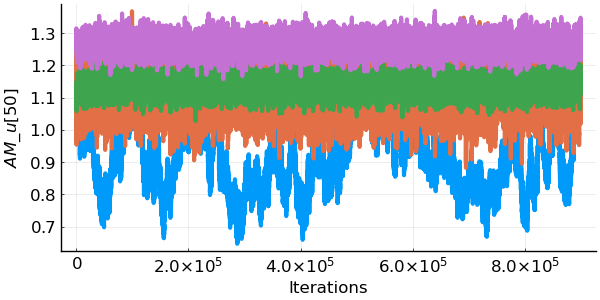

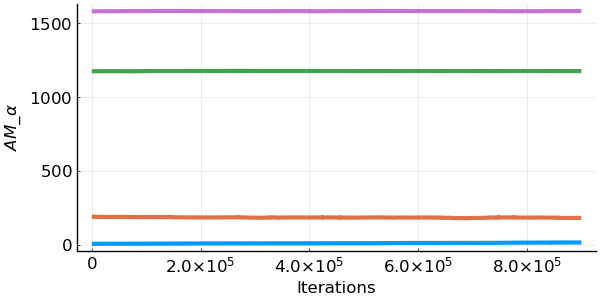

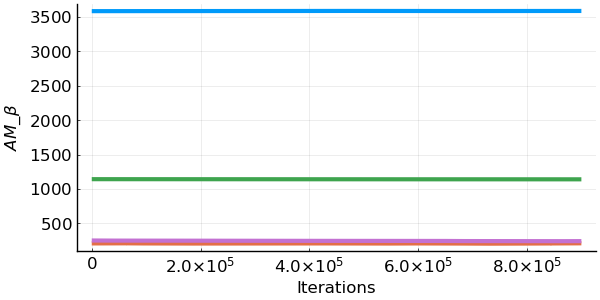

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250602code_TL/notebooks/results_section_6_1_AM_10^6/chain_AM_beta.png"

In [41]:
# Generate figure
Plots.pyplot()
# Create the traceplot
p_AM_u = StatsPlots.plot(
    AM_u_j, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"AM\_u[50]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_AM_u)
# Save the plot
savefig(p_AM_u, joinpath(results_dir, "chain_AM_u50.png"))  # Save as PNG

# Generate figure
Plots.pyplot()
# Create the traceplot
p_AM_alpha = StatsPlots.plot(
    AM_α, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"AM\_α",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_AM_alpha)
# Save the plot
savefig(p_AM_alpha, joinpath(results_dir, "chain_AM_alpha.png"))  # Save as PNG

# Create the traceplot
p_AM_beta = StatsPlots.plot(
    AM_β, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"AM\_β",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_AM_beta)
# Save the plot
savefig(p_AM_beta, joinpath(results_dir, "chain_AM_beta.png"))  # Save as PNG

### Multivariate potential scale reduction factor (MPSRF)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


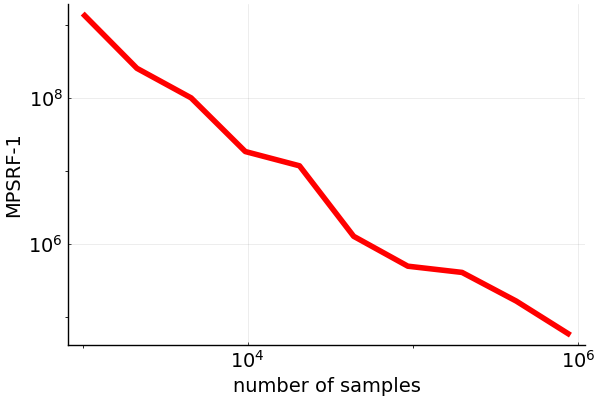

The last value of the MPSRF is
56926.02646128902

In [42]:
# Compute the MPSRF versus number of samples 
num_points = 10  # Number of equidistant points
nr_aux = length(AM_chn[:, 1, 1])
increments = Int.( ceil.( maprange(log, 10^3, nr_aux, length=num_points) ))
# maprange function in pkg FlexiMaps

# Array to store MPSRF values
AM_MPSRF_values = Float64[]

# Compute MPSRF for each subset of the chain
@showprogress for n in increments 
    AM_MPSRF = gelmandiag_multivariate(AM_chn[1:n, :, :] )
    push!(AM_MPSRF_values, AM_MPSRF[2])
end

# Generate figure
Plots.pyplot()

# Set tick locations and labels
xticks = [10^1, 10^2, 10^3, 10^4, 10^5, 10^6]
yticks = [10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2)]

# Create the plot 
plot_AM_MPSRF = plot(increments, AM_MPSRF_values.-1; 
    lw=4, ls=:solid, color = :red )

# Make some cosmetic changes to the plot 
plot!( plot_AM_MPSRF, 
    xscale=:log10, yscale=:log10, # log scale for x-axis and labels
    xlabel="number of samples", ylabel="MPSRF-1", # labels 
    tickfontsize=14, labelfontsize=14, legend=false,
    # xticks=xticks, yticks=yticks
)

# Display the plot
display(plot_AM_MPSRF)
# Save the plot
savefig(plot_AM_MPSRF, joinpath(results_dir, "MPSRF_AM.png"))  # Save as PNG

println("The last value of the MPSRF is")
print(AM_MPSRF_values[end])

In [43]:
display(AM_MPSRF_values)

10-element Vector{Float64}:
      1.4146544581150227e9
      2.5249451697020006e8
      9.961604536591908e7
      1.839328267909827e7
      1.1737658901551241e7
      1.2762296689620516e6
 498025.56360572897
 409464.8283137074
 166094.94033818325
  56926.02646128902

### Effective sample size (ESS)

In [44]:
AM_ESS = ess(AM_chn)

# Assuming ESS_original is a DataFrame or similar structure
AM_ess_values = AM_ESS[:,2]  # Extract the 'ess' column

# Compute the minimum, maximum, mean, and median
@show AM_min_ess = minimum(AM_ess_values)
@show AM_max_ess = maximum(AM_ess_values)
@show AM_mean_ess = mean(AM_ess_values)
@show AM_median_ess = median(AM_ess_values)

# Wall duration to generate samples
@show AM_wall_duration

# Compute the minimum, maximum, mean, and median per second 
@show AM_min_ess_perSec = AM_min_ess/AM_wall_duration
@show AM_max_ess_perSec = AM_max_ess/AM_wall_duration
@show AM_mean_ess_perSec = AM_mean_ess/AM_wall_duration
@show AM_median_ess_perSec = AM_median_ess/AM_wall_duration

AM_min_ess = minimum(AM_ess_values) = 7202.255433414769
AM_max_ess = maximum(AM_ess_values) = 9245.619972614524
AM_mean_ess = mean(AM_ess_values) = 8418.099841888345
AM_median_ess = median(AM_ess_values) = 8392.253662004026
AM_wall_duration = 13.323
AM_min_ess_perSec = AM_min_ess / AM_wall_duration = 540.5881132939104
AM_max_ess_perSec = AM_max_ess / AM_wall_duration = 693.9593164163119
AM_mean_ess_perSec = AM_mean_ess / AM_wall_duration = 631.8471696981419
AM_median_ess_perSec = AM_median_ess / AM_wall_duration = 629.9072027324196


629.9072027324196

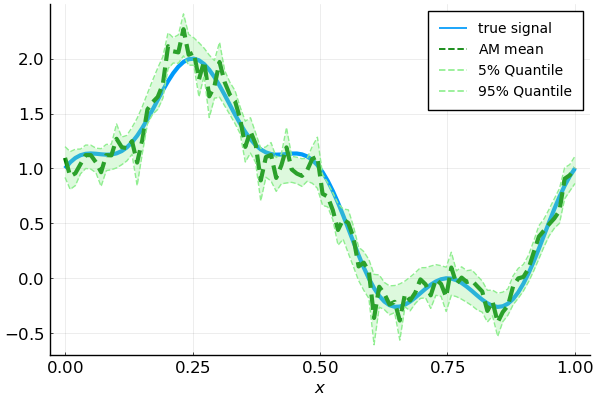

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250602code_TL/notebooks/results_section_6_1_AM_10^6/quantile_AM.png"

In [45]:
# Illustrate the mean and variance of u 

# Extract the samples of u
AM_u_samples = get(AM_chn, :u).u

# Compute the pointwise mean and variance of the samples
AM_u_mean = [mean(AM_u_samples[i]) for i in 1:N]
AM_u_lower_quantile = [quantile(vec(AM_u_samples[i]), 0.05) for i in 1:N]  # 5% quantile
AM_u_upper_quantile = [quantile(vec(AM_u_samples[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Convert to vectors for plotting
AM_u_lower_quantile = collect(AM_u_lower_quantile)
AM_u_upper_quantile = collect(AM_u_upper_quantile)

pyplot() 
# Create the plot for the underlying true function
plot_AM_var = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add AM mean
Plots.plot!(plot_AM_var, 
    xx, AM_u_mean;
    label=L"\text{AM mean}",
    lw=3, ls=:dash, lc=:green
)
# Add AM quantile
Plots.plot!(plot_AM_var, 
    xx, AM_u_lower_quantile; 
    label="5% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add AM quantile
Plots.plot!(plot_AM_var, 
    xx, AM_u_upper_quantile; 
    label="95% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add shaded region between the quantiles for x
Plots.plot!(plot_AM_var,
    xx, AM_u_lower_quantile, fillrange = AM_u_upper_quantile, 
    label=false, fillalpha = 0.3, lw=0, color=:lightgreen
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_AM_var,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_AM_var)
# Save the plot
savefig(plot_AM_var, joinpath(results_dir, "quantile_AM.png"))  # Save as PNG

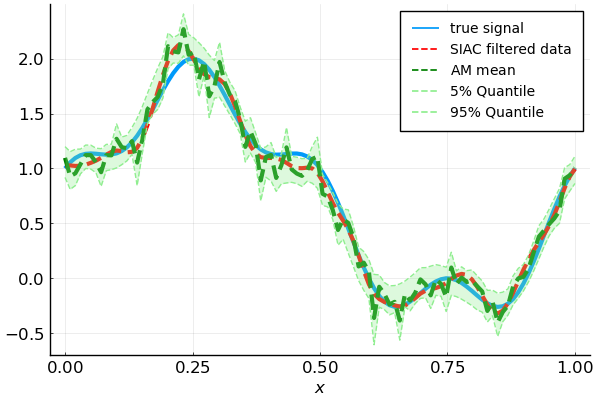

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250602code_TL/notebooks/results_section_6_1_AM_10^6/plot_add_AM.png"

In [46]:
# additional plot including:  (i) the true signal, (ii) the SIAC-filtered data, (iii) the BCD MAP estimate, and (iv) the Gibbs mean + quantiles.
pyplot() 
# Create the plot for the underlying true function
plot_add = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add SIAC filtered noisy data 
Plots.plot!(plot_add, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Add AM mean
Plots.plot!(plot_add, 
    xx, AM_u_mean;
    label=L"\text{AM mean}",
    lw=3, ls=:dash, lc=:green
)
# Add AM quantile
Plots.plot!(plot_add, 
    xx, AM_u_lower_quantile; 
    label="5% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add AM quantile
Plots.plot!(plot_add, 
    xx, AM_u_upper_quantile; 
    label="95% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add shaded region between the quantiles for x
Plots.plot!(plot_add,
    xx, AM_u_lower_quantile, fillrange = AM_u_upper_quantile, 
    label=false, fillalpha = 0.3, lw=0, color=:lightgreen
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_add,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_add)
# Save the plot
savefig(plot_add, joinpath(results_dir, "plot_add_AM.png"))  # Save as PNG